In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
from torch_geometric.nn import Node2Vec
from torch_geometric.data import Data

# Load data

In [2]:
bp_db = pd.read_csv("../data/bp_db.csv", index_col=0)
bp_db.head()

,ENSEMBL,GO
0,ENSG00000000003,GO:0039532
1,ENSG00000000005,GO:0001937
2,ENSG00000000005,GO:0016525
3,ENSG00000000419,GO:0006488
4,ENSG00000000419,GO:0006506


In [3]:
counts1 = pd.read_csv("../data/counts1.csv", index_col=0)
counts1.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSGR0000167393,ENSGR0000169084,ENSGR0000169093,ENSGR0000178605,ENSGR0000182378,ENSGR0000185291,ENSGR0000198223,ENSGR0000214717,ENSGR0000223511,ENSGR0000223773
089357B,14,7,103,241,72,2057,30,60,207,367,...,1,0,0,0,0,0,0,0,0,0
089366A,11,2,194,511,110,3325,36,111,186,530,...,0,0,0,0,0,0,1,0,0,1
089412B,8,0,312,450,106,3751,45,160,325,653,...,0,0,0,0,0,0,1,0,0,0
089425B,9,0,135,496,133,2758,26,93,182,620,...,0,0,0,0,0,0,0,0,0,0
089687A,4,0,89,267,49,2181,24,75,122,263,...,0,0,0,0,0,0,1,0,0,0


In [4]:
pheno1 = pd.read_csv("../data/pheno1.csv", index_col=0)
pheno1.drop(["diagnosis"], axis=1, inplace=True)
pheno1["condition"] = pheno1["condition"].apply(lambda x: 0 if x == "Control" else 1)
pheno1.head()

,age,sex,lithium,condition
089357B,18,F,0,0
089366A,19,F,0,0
089412B,23,F,0,0
089425B,47,F,0,0
089687A,52,F,0,0


# Train Node Embeddings from Graph

In [5]:
bp_graph = nx.read_gml("../data/bp_graph.gml")

In [6]:
bp_db_go = sorted(set(bp_graph.nodes))

map_int_go = {int(idx): go for idx, go in enumerate(bp_db_go)}
map_go_int = {go: idx for idx, go in map_int_go.items()}

_graph = nx.relabel_nodes(bp_graph, map_go_int, copy=False)
edge_index = torch.tensor(list(_graph.edges()), dtype=torch.long).t().contiguous()

data = Data(x=None, edge_index=edge_index)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(data.edge_index, embedding_dim=8, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=4, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.001)

In [8]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [9]:
losses = []
for epoch in range(1, 100):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 1.3259
Epoch: 02, Loss: 1.1262
Epoch: 03, Loss: 1.0325
Epoch: 04, Loss: 0.9776
Epoch: 05, Loss: 0.9390
Epoch: 06, Loss: 0.9115
Epoch: 07, Loss: 0.8904
Epoch: 08, Loss: 0.8741
Epoch: 09, Loss: 0.8609
Epoch: 10, Loss: 0.8500
Epoch: 11, Loss: 0.8404
Epoch: 12, Loss: 0.8324
Epoch: 13, Loss: 0.8258
Epoch: 14, Loss: 0.8198
Epoch: 15, Loss: 0.8141
Epoch: 16, Loss: 0.8095
Epoch: 17, Loss: 0.8057
Epoch: 18, Loss: 0.8016
Epoch: 19, Loss: 0.7982
Epoch: 20, Loss: 0.7954
Epoch: 21, Loss: 0.7927
Epoch: 22, Loss: 0.7902
Epoch: 23, Loss: 0.7882
Epoch: 24, Loss: 0.7857
Epoch: 25, Loss: 0.7842
Epoch: 26, Loss: 0.7825
Epoch: 27, Loss: 0.7808
Epoch: 28, Loss: 0.7796
Epoch: 29, Loss: 0.7781
Epoch: 30, Loss: 0.7770
Epoch: 31, Loss: 0.7758
Epoch: 32, Loss: 0.7750
Epoch: 33, Loss: 0.7739
Epoch: 34, Loss: 0.7732
Epoch: 35, Loss: 0.7723
Epoch: 36, Loss: 0.7717
Epoch: 37, Loss: 0.7710
Epoch: 38, Loss: 0.7705
Epoch: 39, Loss: 0.7701
Epoch: 40, Loss: 0.7696
Epoch: 41, Loss: 0.7691
Epoch: 42, Loss:

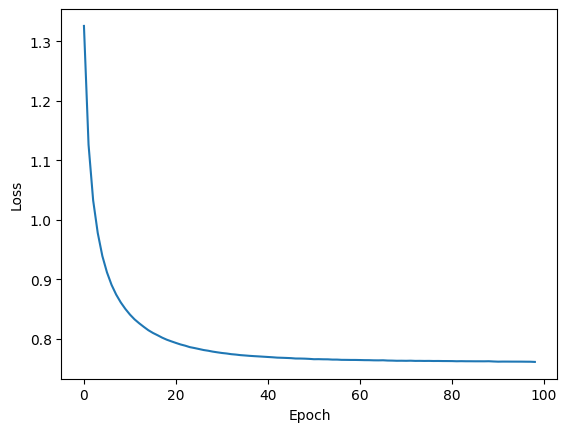

In [10]:
# draw loss curve
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
go_embedding = model()  # go_index -> go_embedding
go_embedding.shape

torch.Size([9917, 8])

In [12]:
_embedding = go_embedding.cpu().detach().numpy()

map_int_gene = {int(idx): gene for idx, gene in enumerate(counts1.columns)}
map_gene_int = {gene: idx for idx, gene in map_int_gene.items()}

# convert to gene_index -> go_embedding
embedding_gene = np.random.randn(len(counts1.columns), _embedding.shape[1])
for idx, gene in map_int_gene.items():
    if gene in map_go_int:
        embedding_gene[idx] = _embedding[map_go_int[gene]]

embedding_gene = torch.tensor(embedding_gene, dtype=torch.float32, device=device)
embedding_gene.shape

torch.Size([52645, 8])

In [13]:
torch.save(embedding_gene, '../data/embedding_gene.pt')

# process the data

In [40]:
# add age, sex, lithium of pheno1 to counts1
tmp_pheno1 = pheno1[["age", "sex", "lithium"]].apply(lambda x: x.replace("M", 0).replace("F", 1))  # chagne sex to 0, 1
counts1_merge = pd.merge(counts1, tmp_pheno1, left_index=True, right_index=True)

counts1_merge = (counts1_merge - counts1_merge.mean()) / counts1_merge.std()
counts1_merge.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSGR0000178605,ENSGR0000182378,ENSGR0000185291,ENSGR0000198223,ENSGR0000214717,ENSGR0000223511,ENSGR0000223773,age,sex,lithium
089357B,2.110648,4.704691,-0.899272,-1.436269,-1.132860,-1.111674,-0.804400,-1.458287,-0.629450,-1.040200,...,-0.152399,-0.453101,-0.212458,-0.502577,-0.45051,-0.222561,-0.226593,-2.043569,0.879916,-0.720677
089366A,1.348549,1.129061,-0.091576,0.088378,-0.357019,-0.170067,-0.695273,-0.660205,-0.785903,-0.267949,...,-0.152399,-0.453101,-0.212458,-0.146685,-0.45051,-0.222561,2.492525,-1.972198,0.879916,-0.720677
089412B,0.586450,-0.301190,0.955766,-0.256079,-0.438687,0.146277,-0.531583,0.106580,0.249663,0.314793,...,-0.152399,-0.453101,-0.212458,-0.146685,-0.45051,-0.222561,-0.226593,-1.686712,0.879916,-0.720677
089425B,0.840483,-0.301190,-0.615247,0.003676,0.112569,-0.591117,-0.877151,-0.941881,-0.815703,0.158447,...,-0.152399,-0.453101,-0.212458,-0.502577,-0.45051,-0.222561,-0.226593,0.026202,0.879916,-0.720677
089687A,-0.429682,-0.301190,-1.023533,-1.289451,-1.602448,-1.019593,-0.913527,-1.223557,-1.262710,-1.532924,...,-0.152399,-0.453101,-0.212458,-0.146685,-0.45051,-0.222561,-0.226593,0.383059,0.879916,-0.720677


In [41]:
bp_db_genes = set(bp_db.ENSEMBL)

In [42]:
dataset = []
input_dim = None

for row in counts1_merge.iterrows():
    idx = row[0]
    values = row[1]
    _data = {
        "gene_idx": [],
        "gene_value": [],
        "other_info": []
    }
    for k, v in values.items():
        if k in map_gene_int:
            _data["gene_idx"].append(map_gene_int[k])
            _data["gene_value"].append(v)
        else:
            _data["other_info"].append(v)
    dataset.append(_data)
    if input_dim is None:
        input_dim = [len(_data["gene_idx"]), len(_data["gene_value"]), len(_data["other_info"])]

input_dim

[52645, 52645, 3]

In [43]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        gene_idx = torch.tensor(sample['gene_idx'], dtype=torch.long, device=device)
        gene_value = torch.tensor(sample['gene_value'], dtype=torch.float, device=device)
        other_info = torch.tensor(sample['other_info'], dtype=torch.float, device=device)

        return {
            'gene_idx': gene_idx,
            'gene_value': gene_value,
            'other_info': other_info
        }, torch.tensor(self.y[idx], dtype=torch.long, device=device)

In [44]:
from sklearn.model_selection import train_test_split

X = dataset
y = pheno1["condition"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(len(X_train), len(X_test))

310 134


In [45]:
train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = MyDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# DNN Classifier with Gene Embedding

In [46]:
import torch.nn as nn
import torch.nn.functional as F


class MyModel(nn.Module):
    def __init__(self, node_embedding, input_dim, output_dim):
        super().__init__()

        self.embedding = node_embedding
        #self.embedding.requires_grad = False
        self.fc0_1 = nn.Linear(9, 128)
        self.fc0_2 = nn.Linear(128, 1)

        self.fc1 = nn.Linear(sum(input_dim), 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.05)

        self.relu = nn.ReLU()

    def forward(self, X):
        gene_idx = X['gene_idx']  # (B, N_1)
        gene_value = X['gene_value']  # (B, N_1)
        other_info = X['other_info']  # (B, N_2)

        gene_embedding = self.embedding[gene_idx]  # (B, N_1, 8)
        gene_embedding = torch.concat([gene_embedding, gene_value.unsqueeze(2)], dim=2)  # (B, N_1, 9)
        gene_embedding = self.fc0_1(gene_embedding)  # (B, N_1, 128)
        gene_embedding = self.relu(gene_embedding)
        gene_embedding = self.fc0_2(gene_embedding).squeeze(2)  # (B, N_1)

        output = torch.cat([gene_embedding, gene_value, other_info], dim=1)  # (B, N_1 * 2 + N_3)

        output = self.fc1(output)  # (B, 512)
        output = self.relu(output)
        output = self.dropout1(output)

        output = self.fc2(output)  # (B, 128)
        output = self.relu(output)
        output = self.dropout2(output)

        return self.fc3(output)  # (B, 2)

In [47]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    total_correct = 0
    total_instances = 0

    model.train()

    for X, y in iterator:
        optimizer.zero_grad()

        # Assuming your model's forward method automatically handles padding, then no need to pack sequence here
        predictions = model(X)

        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Compute the number of correct predictions
        _, predicted_classes = predictions.max(dim=1)
        correct_predictions = (predicted_classes == y).float()  # Convert to float for summation
        total_correct += correct_predictions.sum().item()
        total_instances += y.size(0)

    epoch_acc = total_correct / total_instances

    return epoch_loss / len(iterator), epoch_acc

#train_loss, train_acc = train(model, train_loader, optimizer, criterion)

In [48]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    total_correct = 0
    total_instances = 0

    model.eval()

    with torch.no_grad():
        for X, y in iterator:
            predictions = model(X)

            loss = criterion(predictions, y)
            epoch_loss += loss.item()

            # Compute the number of correct predictions
            _, predicted_classes = predictions.max(dim=1)
            correct_predictions = (predicted_classes == y).float()  # Convert to float for summation
            total_correct += correct_predictions.sum().item()
            total_instances += y.size(0)

    epoch_acc = total_correct / total_instances
    return epoch_loss / len(iterator), epoch_acc

In [49]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs, elapsed_time

In [50]:
embedding_gene = torch.load('../data/embedding_gene.pt')
model = MyModel(node_embedding=embedding_gene, input_dim=input_dim, output_dim=2)
optimizer = optim.SGD(model.parameters(), lr=0.001)
model = model.to(device)

N_EPOCHS = 40

best_valid_loss = float('inf')

best_valid_acc = 0

elapsed_times = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs, elapsed_time = epoch_time(start_time, end_time)
    elapsed_times.append(elapsed_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        #torch.save(model.state_dict(), '../data/final_model.pt')

    if epoch % 1 == 0:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs:.3f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.3f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.3f}%')

avg_elapsed_time = sum(elapsed_times) / len(elapsed_times)
print(f'Avg Epoch Time: {avg_elapsed_time:.3f}s')
print(f'Best Val. Loss: {best_valid_loss:.3f} | Best Val. Acc: {best_valid_acc * 100:.3f}%')

Epoch: 01 | Epoch Time: 0m 2.986s
	Train Loss: 0.668 | Train Acc: 60.323%
	 Val. Loss: 0.664 |  Val. Acc: 61.940%
Epoch: 02 | Epoch Time: 0m 3.141s
	Train Loss: 0.576 | Train Acc: 73.871%
	 Val. Loss: 0.638 |  Val. Acc: 61.940%
Epoch: 03 | Epoch Time: 0m 3.157s
	Train Loss: 0.468 | Train Acc: 85.161%
	 Val. Loss: 0.660 |  Val. Acc: 61.940%
Epoch: 04 | Epoch Time: 0m 3.235s
	Train Loss: 0.379 | Train Acc: 90.323%
	 Val. Loss: 0.581 |  Val. Acc: 67.910%
Epoch: 05 | Epoch Time: 0m 3.234s
	Train Loss: 0.292 | Train Acc: 96.452%
	 Val. Loss: 0.556 |  Val. Acc: 67.910%
Epoch: 06 | Epoch Time: 0m 3.219s
	Train Loss: 0.219 | Train Acc: 97.419%
	 Val. Loss: 0.478 |  Val. Acc: 83.582%
Epoch: 07 | Epoch Time: 0m 3.282s
	Train Loss: 0.156 | Train Acc: 99.032%
	 Val. Loss: 0.510 |  Val. Acc: 73.134%
Epoch: 08 | Epoch Time: 0m 3.250s
	Train Loss: 0.113 | Train Acc: 99.355%
	 Val. Loss: 0.520 |  Val. Acc: 74.627%
Epoch: 09 | Epoch Time: 0m 3.297s
	Train Loss: 0.086 | Train Acc: 99.355%
	 Val. Loss: 0

# DNN Classifier without Gene Embedding

In [51]:
import torch.nn as nn
import torch.nn.functional as F


class MyModelBaseline(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(sum(input_dim[1:]), 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.05)

        self.relu = nn.ReLU()

    def forward(self, X):
        gene_value = X['gene_value']  # (B, N_1)
        other_info = X['other_info']  # (B, N_2)
        output = torch.cat([gene_value, other_info], dim=1)  # (B, N_1 + N_3)

        output = self.fc1(output)  # (B, 512)
        output = self.relu(output)
        output = self.dropout1(output)

        output = self.fc2(output)  # (B, 128)
        output = self.relu(output)
        output = self.dropout2(output)

        return self.fc3(output)  # (B, 2)

In [52]:
model = MyModelBaseline(input_dim=input_dim, output_dim=2)
optimizer = optim.SGD(model.parameters(), lr=0.001)
model = model.to(device)

N_EPOCHS = 40

best_valid_loss = float('inf')

best_valid_acc = 0

elapsed_times = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs, elapsed_time = epoch_time(start_time, end_time)
    elapsed_times.append(elapsed_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        #torch.save(model.state_dict(), '../data/final_model.pt')

    if epoch % 1 == 0:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs:.3f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.3f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.3f}%')

avg_elapsed_time = sum(elapsed_times) / len(elapsed_times)
print(f'Avg Epoch Time: {avg_elapsed_time:.3f}s')
print(f'Best Val. Loss: {best_valid_loss:.3f} | Best Val. Acc: {best_valid_acc * 100:.3f}%')

Epoch: 01 | Epoch Time: 0m 2.563s
	Train Loss: 0.668 | Train Acc: 59.032%
	 Val. Loss: 0.682 |  Val. Acc: 61.194%
Epoch: 02 | Epoch Time: 0m 2.626s
	Train Loss: 0.577 | Train Acc: 77.742%
	 Val. Loss: 0.644 |  Val. Acc: 65.672%
Epoch: 03 | Epoch Time: 0m 2.625s
	Train Loss: 0.495 | Train Acc: 85.806%
	 Val. Loss: 0.632 |  Val. Acc: 64.925%
Epoch: 04 | Epoch Time: 0m 2.625s
	Train Loss: 0.422 | Train Acc: 89.677%
	 Val. Loss: 0.607 |  Val. Acc: 70.896%
Epoch: 05 | Epoch Time: 0m 2.625s
	Train Loss: 0.344 | Train Acc: 93.548%
	 Val. Loss: 0.570 |  Val. Acc: 71.642%
Epoch: 06 | Epoch Time: 0m 2.641s
	Train Loss: 0.278 | Train Acc: 96.774%
	 Val. Loss: 0.576 |  Val. Acc: 70.149%
Epoch: 07 | Epoch Time: 0m 2.625s
	Train Loss: 0.215 | Train Acc: 98.065%
	 Val. Loss: 0.540 |  Val. Acc: 74.627%
Epoch: 08 | Epoch Time: 0m 3.594s
	Train Loss: 0.162 | Train Acc: 99.677%
	 Val. Loss: 0.544 |  Val. Acc: 73.881%
Epoch: 09 | Epoch Time: 0m 3.141s
	Train Loss: 0.131 | Train Acc: 99.355%
	 Val. Loss: 0